## CICS 397A Final Project: Exploring Economic Mobility Data from Opportunity Insights


In [61]:
# importing all the libraries we would be using for this project.
import os.path
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import  matplotlib.pyplot as plt

In [62]:
# First we read in the social_capital_county.csv data file and clean the data
data = pd.read_csv("social_capital_county.csv")
data.set_index('county', inplace = True)
data.replace(r'^\s*$',np.nan, regex = True, inplace = True)
data.dropna(inplace = True)
data

,county_name,num_below_p50,pop2018,ec_county,ec_se_county,child_ec_county,child_ec_se_county,ec_grp_mem_county,ec_high_county,ec_high_se_county,...,child_exposure_county,child_high_exposure_county,bias_grp_mem_county,bias_grp_mem_high_county,child_bias_county,child_high_bias_county,clustering_county,support_ratio_county,volunteering_rate_county,civic_organizations_county
county,,,,,,,,,,,,,,,,,,,,,
1001,"Autauga, Alabama",5922.39210,55200.0,0.72077,0.00831,1.11754,0.02467,0.77223,1.21372,0.01019,...,1.14816,1.19944,0.05526,-0.22748,0.02668,-0.08229,0.10347,0.98275,0.04355,0.01518
1003,"Baldwin, Alabama",15458.39600,208107.0,0.74313,0.00661,0.83064,0.01629,0.76215,1.28302,0.00757,...,0.84588,1.00797,0.02950,-0.21519,0.01802,-0.05241,0.09624,0.98684,0.06117,0.01526
1005,"Barbour, Alabama",4863.97360,25782.0,0.41366,0.00978,0.58541,0.02707,0.35927,0.91897,0.02199,...,0.63306,0.71967,0.13457,-0.34086,0.07528,-0.19714,0.14911,0.99911,0.02093,0.01474
1007,"Bibb, Alabama",3061.49340,22527.0,0.63152,0.01175,0.72265,0.03027,0.68094,1.06378,0.01476,...,0.71433,0.72395,0.04108,-0.27727,-0.01165,-0.15993,0.14252,0.99716,0.05294,0.01439
1009,"Blount, Alabama",6740.91160,57645.0,0.72562,0.00985,0.76096,0.02466,0.79584,1.10569,0.01163,...,0.74821,0.79375,0.00217,-0.24946,-0.01704,-0.08745,0.11243,0.99069,0.05704,0.01724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,"Sweetwater, Wyoming",2402.96900,44117.0,0.96235,0.01280,1.14781,0.02794,1.13449,1.32399,0.01177,...,1.12164,1.12907,0.09519,-0.12030,-0.02333,-0.08683,0.10809,0.99710,0.07321,0.01225
56039,"Teton, Wyoming",783.24982,23059.0,1.07623,0.01744,1.23113,0.04692,1.13296,1.63551,0.00848,...,1.32874,1.35341,0.14337,-0.11958,0.07346,-0.07364,0.09253,0.98648,0.09747,0.03223
56041,"Uinta, Wyoming",2174.06180,20609.0,0.95452,0.01404,1.04595,0.03455,0.92831,1.32040,0.01351,...,1.05446,1.06284,0.13816,-0.12194,0.00808,-0.06074,0.11204,0.99479,0.06942,0.01222


## Visualizations

In [63]:
# We start by taking a copy of the data and splitting the county_names column to get the name of the state and the county in two seperate columns
new_data = data['county_name'].str.split(", ", n = 1, expand = True)
visual_data = data[['pop2018','num_below_p50', 'ec_county','volunteering_rate_county','civic_organizations_county']]
visual_data["states"] = new_data[1]
visual_data["county_name"] = new_data[0]
visual_data.drop(columns =["county_name"], inplace = True)

/var/folders/fs/w237dm613w95cl09y95vfhy00000gn/T/ipykernel_43077/2598059350.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fs/w237dm613w95cl09y95vfhy00000gn/T/ipykernel_43077/2598059350.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [64]:
# Calculating the sum of all the rows grouped by the state for the barplot
bar_data = visual_data.groupby(by = 'states').sum()
bar_data

,pop2018,num_below_p50,ec_county,volunteering_rate_county,civic_organizations_county
states,,,,,
Alabama,4800062.0,5.945022e+05,37.006660,2.62703,0.91152
Alaska,699092.0,6.882624e+04,15.896420,2.14754,0.38115
Arizona,6946685.0,6.506165e+05,10.378920,0.93180,0.25776
Arkansas,2920915.0,3.858237e+05,45.995280,5.07833,1.09577
California,39144684.0,4.559372e+06,44.986300,4.20621,1.02655
Colorado,5455931.0,4.102923e+05,43.112780,3.41552,1.00424
Connecticut,3581504.0,2.375277e+05,7.589540,0.56224,0.14553
Delaware,949495.0,7.761421e+04,2.344840,0.16945,0.05257
Florida,20573040.0,2.031931e+06,43.475460,3.70898,1.02865


[Text(0.5, 1.0, 'Population by State')]

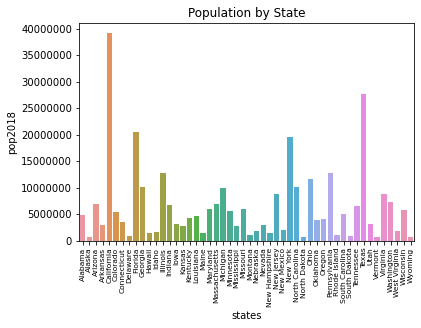

In [65]:
# Plotting a barplot of population distribution of each state of the United States in 2018
plot = sns.barplot(data = bar_data, x = bar_data.index, y = 'pop2018')
plot.ticklabel_format(axis = 'y', style = 'plain')
plot.tick_params(axis = 'x', rotation = 90, labelsize = 7.5)
plot.set(title = "Population by State")

In [66]:
# Calculating the mean of all the rows grouped by the state for the lineplot
line_data = visual_data.groupby(by = 'states').mean()
line_data

,pop2018,num_below_p50,ec_county,volunteering_rate_county,civic_organizations_county
states,,,,,
Alabama,78689.540984,9745.937448,0.606667,0.043066,0.014943
Alaska,43693.250000,4301.639745,0.993526,0.134221,0.023822
Arizona,463112.333333,43374.434769,0.691928,0.062120,0.017184
Arkansas,44256.287879,5845.812924,0.696898,0.076944,0.016603
California,699012.214286,81417.349155,0.803327,0.075111,0.018331
Colorado,121242.911111,9117.605612,0.958062,0.075900,0.022316
Connecticut,447688.000000,29690.961275,0.948693,0.070280,0.018191
Delaware,316498.333333,25871.401667,0.781613,0.056483,0.017523
Florida,316508.307692,31260.469904,0.668853,0.057061,0.015825


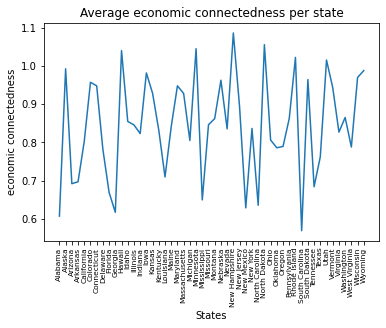

0.5685863613636364


In [67]:
# Plotting the Average economic connectedness across all states in the United States
x_axis = line_data.index
y_axis = line_data['ec_county']
plt.plot(x_axis, y_axis)
plt.title("Average economic connectedness per state")
plt.ylabel("economic connectedness")
plt.xlabel("States")
plt.tick_params(axis = 'x', rotation = 90, labelsize = 7.5)
plt.show()
print(min(line_data['ec_county']))

## Geocoding

In [68]:
# Using the geolocator.geocode function to get the geocode of all the states of United States
geolocator = Nominatim(user_agent = "cics397a")
geo_data = visual_data.groupby(by = 'states').mean()
geo_data.dropna(inplace = True)
states = geo_data.index
geo_data['location'] = geo_data.index.map(geolocator.geocode)
geo_data = geo_data[geo_data['location'].notna()]
geo_data['location']

states
Alabama           (Alabama, United States, (33.2588817, -86.8295...
Alaska            (Alaska, United States, (64.4459613, -149.6809...
Arizona           (Arizona, United States, (34.395342, -111.7632...
Arkansas          (Arkansas, United States, (35.2048883, -92.447...
California        (California, United States, (36.7014631, -118....
Colorado          (Colorado, United States, (38.7251776, -105.60...
Connecticut       (Connecticut, United States, (41.6500201, -72....
Delaware          (Delaware, United States, (38.6920451, -75.401...
Florida           (Florida, United States, (27.7567667, -81.4639...
Georgia           (Georgia, United States, (32.3293809, -83.1137...
Hawaii            (Hawaii, United States, (19.593801499999998, -...
Idaho             (Idaho, United States, (43.6447642, -114.015407))
Illinois          (Illinois, United States, (40.0796606, -89.433...
Indiana           (Indiana, United States, (40.3270127, -86.1746...
Iowa               (Iowa, United States, 

In [69]:
# Getting the Latitudes and Longitudes in seperate columns
geo_data['lat'] = geo_data['location'].apply(lambda z: z.latitude)
geo_data['lon'] = geo_data['location'].apply(lambda z: z.longitude)
print(geo_data)

                      pop2018  num_below_p50  ec_county  \
states                                                    
Alabama          78689.540984    9745.937448   0.606667   
Alaska           43693.250000    4301.639745   0.993526   
Arizona         463112.333333   43374.434769   0.691928   
Arkansas         44256.287879    5845.812924   0.696898   
California      699012.214286   81417.349155   0.803327   
Colorado        121242.911111    9117.605612   0.958062   
Connecticut     447688.000000   29690.961275   0.948693   
Delaware        316498.333333   25871.401667   0.781613   
Florida         316508.307692   31260.469904   0.668853   
Georgia          75057.088889    7935.125885   0.616789   
Hawaii          355488.500000   29699.387550   1.041255   
Idaho            46076.527778    4442.480793   0.855319   
Illinois        133240.427083   12884.019099   0.846172   
Indiana          72145.934783    6452.625919   0.823437   
Iowa             32460.625000    2828.693644   0.982482 

In [70]:
# Plotting a mapbox of Number of children with below-national-median parental household income for each state in the United States
px.set_mapbox_access_token(token = 'pk.eyJ1IjoiYXJubmF2djEyIiwiYSI6ImNsYTE5OW9zZzA1OHQzcHNhNnczaHpoODQifQ.9uzxOzRkD2hDQNTK2Ua64A')
fig = px.scatter_mapbox(geo_data, lat = 'lat', lon = 'lon', color = 'lon', size = 'num_below_p50', zoom = 3.0)
fig.update_layout(mapbox_style = "carto-positron")

## Clustering

In [71]:
# creating a copy of the data for clustering from line_data as it already contains the mean
data_clust = line_data
# Selecting the cluster columns
clust_columns = data_clust[['ec_county', 'volunteering_rate_county','civic_organizations_county']]
df_cluster = clust_columns.dropna()

# Scale the data and performing KMeans clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)
clustering = KMeans(n_clusters=10, random_state=0).fit(df_cluster)
clustering.predict(scaled_data)
clustering.labels_
clustering.cluster_centers_
# Store the cluster assignments
df_cluster["label"] = clustering.labels_

In [72]:
cluster_ec_county = {}
for index, row in df_cluster.reset_index().iterrows():
    clust = row["label"]
    cluster_ec_county.setdefault(clust, []).append(row)

# Printing out the clusters
for cluster, rows in cluster_ec_county.items():
    rows_tuples = [ tuple(row) for row in rows ]
    for row in sorted(rows_tuples):
        print(row[:7])
    print("\n")

('Alabama', 0.6066665575409835, 0.04306606555737705, 0.01494295083442623, 1)
('Georgia', 0.6167890366666667, 0.05146629637037037, 0.015571037071851852, 1)
('Mississippi', 0.6493603093846154, 0.04586969233846154, 0.012317076893846153, 1)
('New Mexico', 0.6284192655555556, 0.06107962922222222, 0.02107111105185185, 1)
('North Carolina', 0.63528614375, 0.05471562475, 0.019296458279166668, 1)


('Alaska', 0.9935262575, 0.1342212499375, 0.0238218750625, 2)
('Iowa', 0.9824821957291667, 0.08775468719791667, 0.021315833343750003, 2)
('Nebraska', 0.9634887705263159, 0.08329052614035087, 0.02195192976842105, 2)
('South Dakota', 0.9652738869444444, 0.07759222230555556, 0.02423805541388889, 2)
('Wisconsin', 0.9706402952941175, 0.08930705867647058, 0.021541617735294116, 2)
('Wyoming', 0.9887318199999999, 0.08986136454545454, 0.02752363636363636, 2)


('Arizona', 0.6919280013333334, 0.062119999733333334, 0.017184000053333332, 5)
('Arkansas', 0.6968981803030303, 0.076944394, 0.01660257580151515, 5)
('

## Classification

In [73]:
# Setting the class label
class_label = "economic connectedness"
# splitting the data column into three equal categories for classification
def convert_to_categorical(s):
    if s >= 1.02:
        return "High Connectedness"
    elif s < 1.02 and s > 0.68:
        return "Average Connectedness"
    else:
        return "Low Connectedness"
class_data = data
class_data.drop(class_data.loc[:, :'county_name'].columns, axis=1, inplace = True)
class_data.dropna(inplace = True)
print(class_data)
class_data[class_label] = class_data['ec_county'].apply(convert_to_categorical)

        num_below_p50   pop2018  ec_county  ec_se_county  child_ec_county  \
county                                                                      
1001       5922.39210   55200.0    0.72077       0.00831          1.11754   
1003      15458.39600  208107.0    0.74313       0.00661          0.83064   
1005       4863.97360   25782.0    0.41366       0.00978          0.58541   
1007       3061.49340   22527.0    0.63152       0.01175          0.72265   
1009       6740.91160   57645.0    0.72562       0.00985          0.76096   
...               ...       ...        ...           ...              ...   
56037      2402.96900   44117.0    0.96235       0.01280          1.14781   
56039       783.24982   23059.0    1.07623       0.01744          1.23113   
56041      2174.06180   20609.0    0.95452       0.01404          1.04595   
56043       872.51544    8129.0    0.90667       0.01928          0.90794   
56045       635.28436    7100.0    0.97840       0.02036          1.09118   

In [74]:
# Creating trainig and testing sets to perform KNN classification
y = class_data[class_label]
X = class_data.drop(columns = ['ec_county', class_label])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

knn_classifier = KNeighborsClassifier(n_neighbors = 40)
knn_classifier.fit(x_train, y_train)
y_predict = knn_classifier.predict(x_test)

# Calculating the accuracy metrics for the classification
acc = metrics.accuracy_score(y_test, y_predict, normalize = True)
print("Accuracy:", acc)

# Calculating the misclassification rate for the classification
new_metric = metrics.zero_one_loss(y_test, y_predict, normalize = False)
print("No. of missclassifications:", new_metric)

Accuracy: 0.6869244935543278
No. of missclassifications: 170


In [75]:
# Performing a 7 fold KNN classification
print(y.value_counts())
scores = cross_val_score(knn_classifier, X, y, cv = 7)
print(scores)

Average Connectedness    1774
Low Connectedness         586
High Connectedness        353
Name: economic connectedness, dtype: int64
[0.68298969 0.66752577 0.68814433 0.71134021 0.66666667 0.68475452
 0.67958656]
